In [1]:
using Plots;

# Group Seminar on Julia Pt. II  
# Parallel Techniques

- Julia's parallel architecture, like MPI, uses message passing between worker processes.
- Distributed Memory architecture $\rightarrow$ Each worker has its own memory.
- It is however more transparent and high level.

## 1. Add worker processes.

In [2]:
workers()

1-element Array{Int64,1}:
 1

In [ ]:
rmprocs(2:5)

In [3]:
addprocs();workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [4]:
[nworkers(),
    nprocs()]

2-element Array{Int64,1}:
 4
 5

   ## 2. Running functions on other processes.

In [5]:
r = remotecall(2, +, 1,1)

RemoteRef{Channel{Any}}(2,1,5)

In [6]:
fetch(r)

2

In [7]:
remotecall_fetch(2, +, 1,1)

2

### `remotecall` and `fetch` are rather "low level" and cumbersome.
### Julia offers convenient macros `@spawn`, `@spawnat`, `@fetch`

In [8]:
@spawn svd(rand(10,10))

RemoteRef{Channel{Any}}(2,1,8)

In [ ]:
fetch(ans)

In [9]:
@fetch svd(rand(10,10))

(
10x10 Array{Float64,2}:
 -0.275074  -0.0947211   0.23333    …   0.13293     0.0220586  -0.0539509 
 -0.321534   0.174334   -0.559078      -0.119445    0.0822099   0.408051  
 -0.280794   0.0759489  -0.509088       0.456731   -0.132516    0.0871879 
 -0.356107   0.346914    0.296662       0.086605   -0.45919    -0.180841  
 -0.328984   0.542221    0.391919      -0.0137745   0.486244    0.314834  
 -0.331348  -0.617001    0.133881   …  -0.208671    0.0530014   0.428384  
 -0.387969   0.0293416  -0.282618      -0.325181    0.243178   -0.664049  
 -0.267539  -0.137816    0.115711       0.463033   -0.333731    0.00287219
 -0.316488  -0.373669    0.131747       0.240453    0.363067   -0.252492  
 -0.273877  -0.0184537   0.0605475     -0.574687   -0.471982    0.0540714 ,

[5.49788599359055,1.5355566796898747,1.3378568732632001,1.1588564114728552,0.8877345852814883,0.7781583530962147,0.6181044366896132,0.4000646477744593,0.2892315199429659,0.014791747585989008],
10x10 Array{Float64,2}:
 -0.3

### Transforming datasets in parallel with `pmap`.

In [10]:
matrices = [ rand(5,5) for i in 1:4 ];
pmap(svd, matrices);

In [11]:
matrices

4-element Array{Array{Float64,2},1}:
 5x5 Array{Float64,2}:
 0.217325  0.4462    0.3937    0.421011  0.503594
 0.286928  0.467984  0.424868  0.601607  0.19769 
 0.482179  0.20294   0.415096  0.617386  0.782388
 0.114345  0.541309  0.785444  0.734967  0.939863
 0.371595  0.307396  0.460695  0.067577  0.529202               
 5x5 Array{Float64,2}:
 0.976702   0.817228  0.731309   0.267841   0.423302
 0.572177   0.208002  0.354461   0.540773   0.748813
 0.0743482  0.873839  0.0327645  0.754689   0.288011
 0.404847   0.092719  0.679736   0.491548   0.286781
 0.073289   0.45576   0.0478941  0.0139971  0.182714
 5x5 Array{Float64,2}:
 0.616848  0.785814    0.937999  0.138046   0.427419
 0.549956  0.222444    0.183118  0.0188677  0.821581
 0.957233  0.404216    0.10738   0.766687   0.678935
 0.112664  0.289247    0.821351  0.618453   0.787634
 0.455525  0.00917284  0.486823  0.786622   0.289695
 5x5 Array{Float64,2}:
 0.440157  0.151524   0.0905587  0.0963736  0.918625
 0.592028  0.0746526  0

In [12]:
function tictoq(ex::Expr)
    tic()
    eval(ex)
    return toq()
end

tictoq (generic function with 1 method)

In [13]:
maxSize = 100;
@time times = hcat([ [size(m[1],1), tictoq(:(pmap(svd, $m))), tictoq( :(map(svd,$m)))]
    for m in [ [rand(k,k) for i in 1:8] for k in 5:maxSize ]]...)';

  6.645683 seconds (398.63 k allocations: 249.621 MB, 1.50% gc time)


[Plots.jl] Initializing backend: pyplot


INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
objc[90344]: Class TKApplication is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Volumes/scratch/Applications/anaconda3/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[90344]: Class TKMenu is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Volumes/scratch/Applications/anaconda3/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[90344]: Class TKContentView is implemented in both /System/Library/Frameworks/Tk.framework/Versions/8.5/Tk and /Volumes/scratch/Applications/anaconda3/lib/libtk8.5.dylib. One of the two will be used. Which one is undefined.
objc[90344]: Class TKWindow is imple


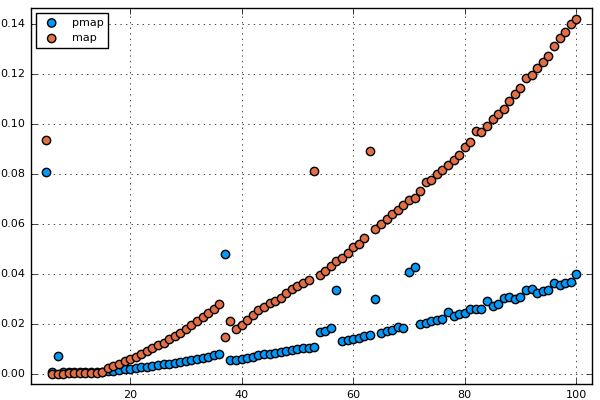

In [14]:
scatter(times[:,1],times[:,2:end],label=[:pmap :map],legend=:topleft)

In [16]:
for i = 1:nworkers()
    local matrices = [ rand(500,500) for j in 1:8 ];
    @time pmap(svd, matrices, pids=workers()[1:i]);
end

  1.346741 seconds (4.57 k allocations: 30.703 MB, 0.95% gc time)
  0.749362 seconds (2.94 k allocations: 32.731 MB, 6.24% gc time)
  0.559290 seconds (3.88 k allocations: 30.706 MB, 1.12% gc time)
  0.436281 seconds (2.97 k allocations: 30.692 MB, 1.17% gc time)


__Caveat:__ `pmap` only suitable for distributing large chunks of work.

In [17]:
@time pmap(x->x+1, collect(1:Int(1e5)));

  7.219656 seconds (25.36 M allocations: 1.480 GB, 4.25% gc time)


In [19]:
@time collect(1:Int(1e5)) + 1 ;

  0.000665 seconds (11 allocations: 1.526 MB)


### `@parallel` to the rescue!

__Scenario:__ Parallel calculations that are reduced (Matrix$\rightarrow$Vector, Vector$\rightarrow$Number)

In [51]:
piEst = @parallel (+) for i = 1:Int(1e9)
    ifelse( abs2(rand()) + abs2(rand()) <= 1, 1, 0)
end
piEst /= (1e9 / 4)

3.141540336

In [52]:
@time randWalk = @parallel (+) for i = 1:Int(1e8)
    randn()
end

  0.161380 seconds (8.86 k allocations: 501.516 KB)


-15743.378167698917

In [25]:
@time reduce(+, randn(Int(1e8)))

  0.822365 seconds (8 allocations: 762.940 MB, 6.30% gc time)


6132.171159517149

In [28]:
s = 0.0
@time for i = 1:Int(1e8)
    s += randn()
end
s

  3.026110 seconds (200.00 M allocations: 2.980 GB, 11.79% gc time)


-7248.59365168165

In [30]:
function randomWalk_serial(L::Int)
    s = 0.0
    for i = 1:L
        s += randn()
    end
    s
end
@time randomWalk_serial(Int(1e8))

  0.476084 seconds (2.62 k allocations: 129.758 KB)


-11485.43758525108

----

__What if we need the results of every run?__  
Naively one could concatenate the results ($=$reduce with `vcat`).

In [31]:
L = Int(1e5);

In [33]:
@time randn(L);

  0.000451 seconds (6 allocations: 781.469 KB)


In [35]:
@time n = @parallel (vcat) for i in 1:L
    randn()
end;

  1.387375 seconds (4.84 k allocations: 2.828 MB)


__Abysmal runtime! __ Note the allocations.  
`vcat` allocates new memory __each__ iteration $\rightarrow$ dynamical resizing of arrays is not a good idea in performance critical code.

Alright, allocate the memory beforehand...

In [ ]:
a = zeros(Int64, L)
@time @parallel for i in 1:L
    a[i] = randn()
end;

Ok, that was fast, but did it do what we wanted?

In [ ]:
println(maximum(a))

__No__, because `a[]` inside the parallel for-loop is a __local variable__ to each process.

__Needed:__ Data structure that is shared between processes.

### Shared Arrays

In [36]:
@everywhere gc()

In [37]:
L = Int(1e8);

In [38]:
ShA = SharedArray(Float64, L, init= S->S[localindexes(S)] = 0);

In [39]:
length(ShA)*8/1024^2

762.939453125

In [40]:
ShA.pids

4-element Array{Int64,1}:
 2
 3
 4
 5

In [41]:
[@fetchfrom i localindexes(ShA) for i in workers()]

4-element Array{Any,1}:
 1:25000000        
 25000001:50000000 
 50000001:75000000 
 75000001:100000000

In [43]:
@time @sync @parallel for i in 1:length(ShA)
    ShA[i] = randn()
end;

  3.944145 seconds (6.64 k allocations: 476.081 KB)


In [49]:
@everywhere function Randn(S::SharedArray)
    for i in localindexes(S)
        S[i] = randn()
    end
end
@time @sync begin 
    for p in ShA.pids
        @async remotecall(p, Randn, ShA)
    end
end

  0.003174 seconds (1.57 k allocations: 134.477 KB)


In [ ]:
ShA[1:10]

In [48]:
function Randn(L::Int)
    a = zeros(Float64,L)
    @time for i in 1:L
        a[i] = randn()
    end
    return a
end;
Randn(L);

  0.528867 seconds



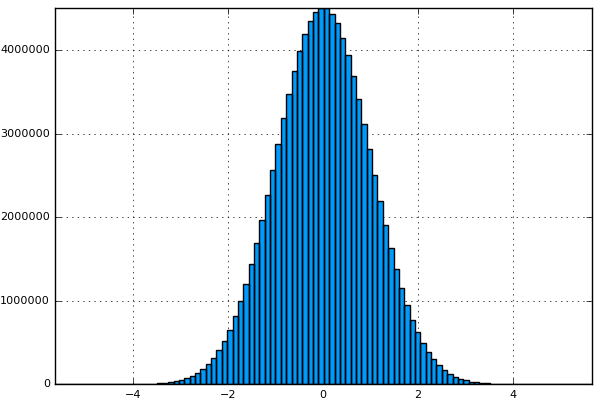

In [50]:
histogram(ShA,nbins=100,legend=:none)